# Deconvolution using Singular Value Decomposition (SVD)

Given a physical system, such as an accelerometer with limited bandwidth, the challenge is to understand its impulse response. The code provided simulates and analyzes this system's response and then applies SVD to deconvolve and retrieve the original signal.

## Highlights:

1. **Initialization**: Key parameters like the noise level, dimensions, characteristic time constant (`T0`), and sigma are set.
2. **Impulse Response Generation**: Based on the equation `g(t) = g0 * t * e^(-t/T0)` for `t ≥ 0` and `g(t) = 0` for `t < 0`, the impulse response of the system is computed and normalized.
3. **System Matrix (G) Construction**: The matrix `G`, representing the system's response, is generated and normalized.
4. **Singular Value Decomposition**: The matrix `G` undergoes SVD, yielding matrices `U`, `S`, and `V`, which are pivotal for the deconvolution process.
5. **Model Construction**: The original or "true" seismic motion (`mtrue`) is formulated. Subsequently, noise-free (`d`) and noisy (`dn`) system responses to this motion are constructed.
6. **Generalized Inverse Solutions**: Utilizing SVD, solutions for the noise-free and noisy data are derived.
7. **Truncated SVD (TSVD)**: To enhance noise robustness, SVD is truncated to a subset of singular values, resulting in a more noise-resistant solution (`m2`).
8. **Visualization**: The code offers plots to visualize singular values, models, data, and resolution matrices, ensuring a comprehensive understanding of the deconvolution process.

In essence, the code demonstrates the power of SVD in deconvolving signals, especially in scenarios where the system's response might be corrupted with noise.


In [24]:
import numpy as np
import matplotlib.pyplot as plt

def generate_time_vector(N):
    """Generate time vector."""
    return np.linspace(-5, 100, N+1)

def generate_G_matrix(t, M, N, T0):
    """Generate the G matrix."""
    G = np.zeros((M, N))
    for i in range(1, M+1):
        for j in range(N):
            tp = t[j] - t[i]
            G[i-1, j] = 0 if tp > 0 else -tp * np.exp(tp / T0)
    deltat = t[1] - t[0]
    return G * deltat

def get_true_model(t, N, sigma):
    """Get the true model."""
    mtrue = (np.exp(-(t[:N] - 8)**2 / (sigma**2 * 2))
            + 0.5 * np.exp(-(t[:N] - 25)**2 / (sigma**2 * 2)))
    return mtrue / np.max(mtrue)

def plot_singular_values(S):
    """Plot singular values."""
    plt.figure()
    plt.semilogy(S, 'ko-', linewidth=2)
    plt.axis('tight')
    plt.xlabel('i', fontsize=14)
    plt.ylabel('$s_i$', fontsize=14)
    plt.title("Singular Values", fontsize=16)
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.show()

def plot_model(t, m, N, label):
    """Plot a model."""
    plt.figure()
    plt.plot(t[:N], m, 'k-', linewidth=2)
    plt.xlim([-5, 100])
    # plt.ylim([0, 1])
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Acceleration (m/s$^2$)', fontsize=14)
    plt.title(label, fontsize=16)
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.show()

def plot_data(t, data, N, label):
    """Plot data."""
    plt.figure()
    plt.plot(t[:N], data, 'k-', linewidth=2)
    plt.xlim([-5, 100])
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('V', fontsize=14)
    plt.title(label, fontsize=16)
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.show()

def plot_resolution_matrix(Rm):
    """Plot the resolution matrix."""
    plt.figure()
    plt.imshow(Rm, cmap='viridis', vmin=np.min(Rm), vmax=np.max(Rm))
    plt.xlabel('j', fontsize=14)
    plt.ylabel('i', fontsize=14)
    plt.colorbar()
    plt.title("Resolution Matrix", fontsize=16)
    plt.show()

def plot_column_of_resolution_matrix(t, Rm, N, column_index):
    """Plot a column of the resolution matrix."""
    plt.figure()
    plt.plot(t[:N], Rm[column_index, :], 'k-', linewidth=2)
    plt.axis('tight')
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Element Value', fontsize=14)
    plt.title(f"Column {column_index} of Resolution Matrix", fontsize=16)
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.show()

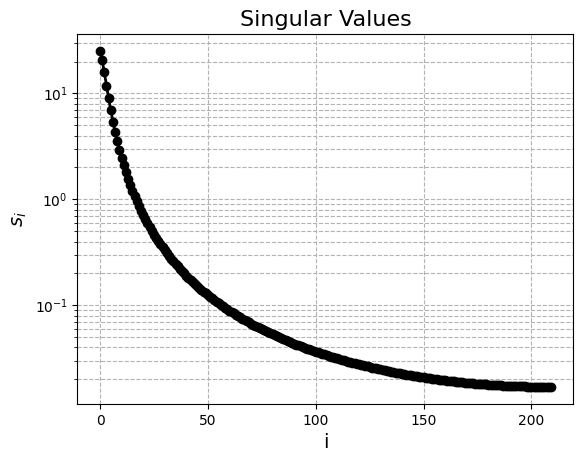

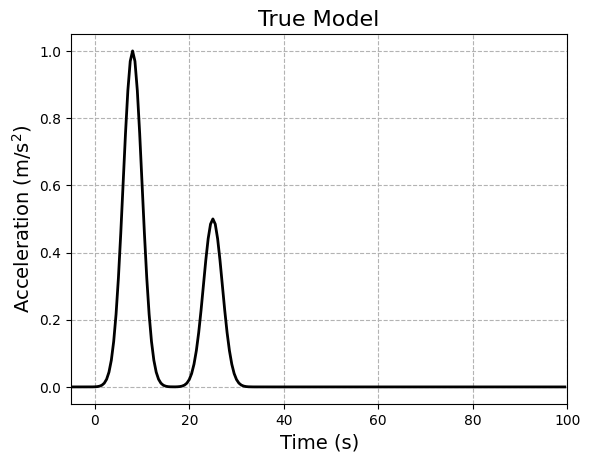

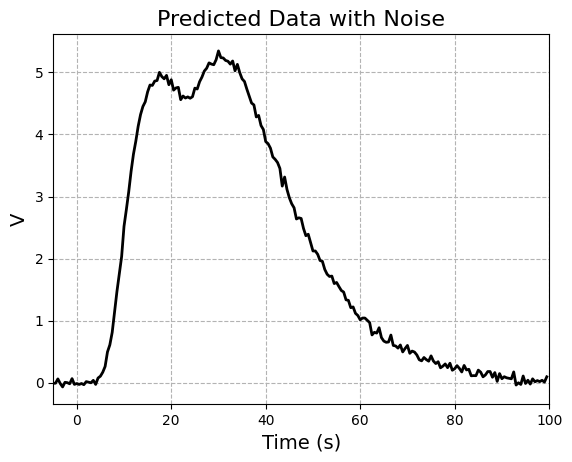

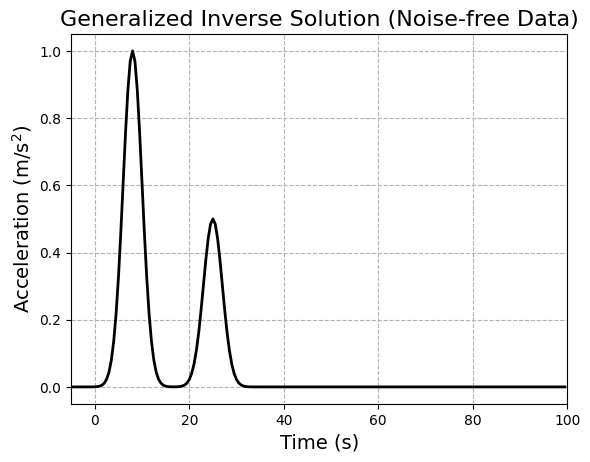

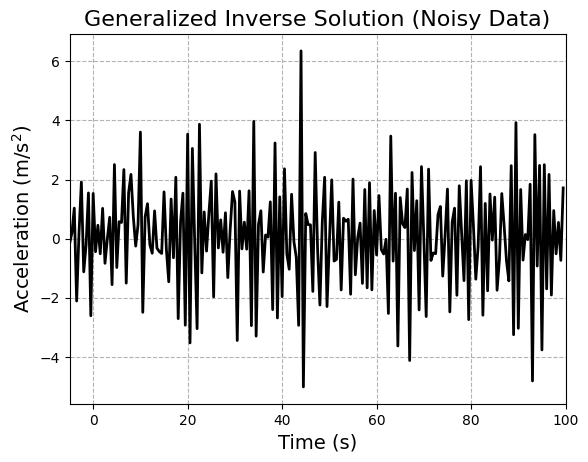

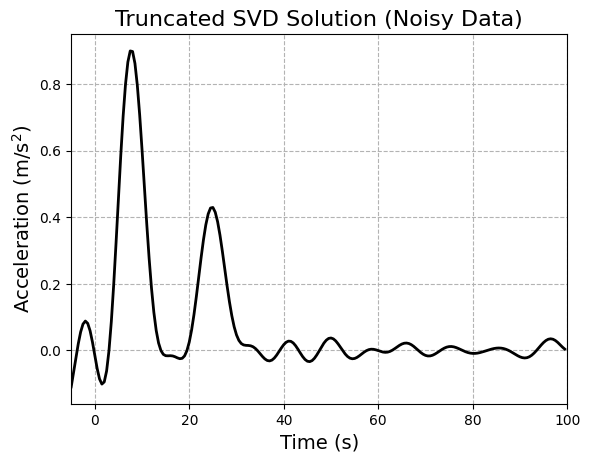

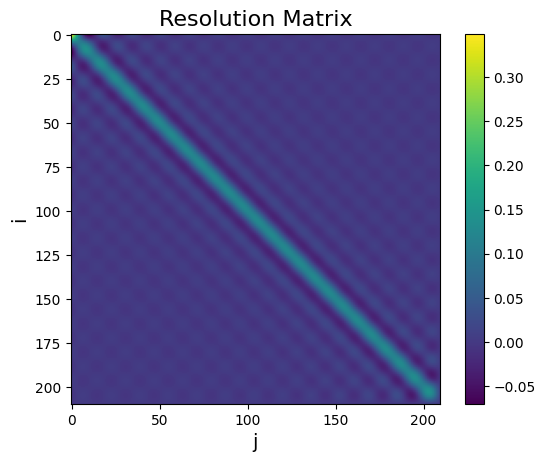

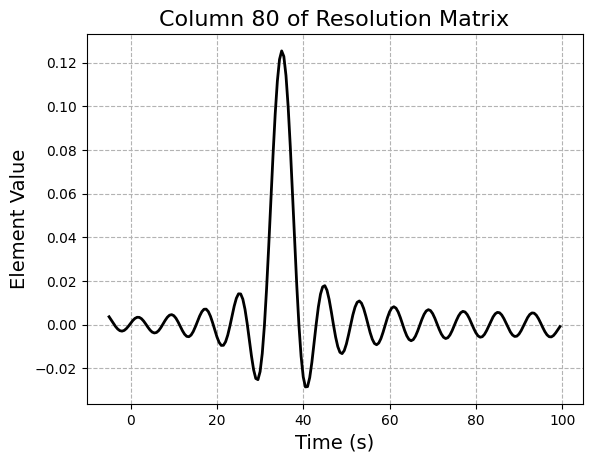

In [25]:
def main():
    # Constants
    noise = 0.05
    N = 210
    M = 210
    T0 = 10
    sigma = 2

    # Generating time vector, instrument impulse response, and G matrix
    t = generate_time_vector(N)
    g = np.zeros(N)
    for i in range(N):
      if t[i] < 0:
          g[i] = 0
      else:
          g[i] = t[i] * np.exp(-t[i] / T0)
    gmax = np.max(g)
    g = g / gmax
    # g = generate_instrument_impulse_response(g, N, T0)
    G = generate_G_matrix(t, M, N, T0)
    G = G/gmax

    # SVD of G matrix
    U, S, Vt = np.linalg.svd(G)
    V = Vt.T

    U = U[:, :N]
    V = V[:, :N]

    mtrue = get_true_model(t, N, sigma)
    d = G @ mtrue
    dn = G @ mtrue + noise * np.random.randn(M)

    # Using SVD with all singular values
    m = V @ np.linalg.inv(np.diag(S[:N])) @ U.T @ d
    m_noise = V @ np.linalg.inv(np.diag(S)) @ U.T @ dn

    # Plot singular values, true model, and data
    plot_singular_values(S)
    plot_model(t, mtrue, N, "True Model")
    plot_data(t, dn, N, "Predicted Data with Noise")

    plot_model(t, m, N, "Generalized Inverse Solution (Noise-free Data)")
    plot_model(t, m_noise, N, "Generalized Inverse Solution (Noisy Data)")

    # Truncate SVD to 26 singular values (TSVD)
    Up = U[:, :26]
    Vp = V[:, :26]
    Sp = np.diag(S[:26])
    m2 = Vp @ np.linalg.inv(Sp) @ Up.T @ dn

    # Plot model using truncated SVD
    plot_model(t, m2, N, "Truncated SVD Solution (Noisy Data)")

    # Get and plot resolution matrix for TSVD solution
    Rm = Vp @ Vp.T
    plot_resolution_matrix(Rm)

    # Plot the 80th column of the model resolution matrix
    plot_column_of_resolution_matrix(t, Rm, N, 80)

main()


# Q2
## Shaw's Problem

Shaw's problem is a classic pedagogical inverse problem where we attempt to deduce the intensity of an incident light on a slit, given the observed diffraction pattern. This problem is mathematically posed as trying to deduce $ m(\theta) $ from the given $ d(s) $.

The matrix representation of this problem is given by:
\[ Gm = d \]

Where:
- $ G $ is the matrix that represents the diffraction process.
- $ m $ is the model (intensity of the incident light on the slit).
- $ d $ is the observed data (diffraction pattern).

---

## Ill-posedness of Shaw's Problem:

An inverse problem is said to be ill-posed if a small change in the observed data can lead to a large change in the computed solution.

1. **Singular Values of $ G $:** The singular values of $ G $ decrease rapidly. This rapid decrease is indicative of the problem being ill-posed. Very small singular values can amplify the noise present in the data, leading to unstable solutions.

2. **Impact of Noise:** When noise is introduced into the data, the solution becomes unstable. This instability is due to the inclusion of small singular values in the series solution of the generalized inverse.

3. **TSVD Recovery:** By truncating the singular values to a rank $ p $ using TSVD, we get a more stable solution. However, the choice of $ p $ is critical. If $ p $ is too large, the solution may be sensitive to noise. If $ p $ is too small, we may lose significant information.

---

## Condition Number and Ill-posedness:

The **condition number** of a matrix is a measure of how sensitive its solution is to changes (or errors) in the input data. For a matrix $ A $, the condition number $ \kappa(A) $ is:

$$ \kappa(A) = \frac{\sigma_{\text{max}}}{\sigma_{\text{min}}} $$

Where $ \sigma_{\text{max}} $ is the largest singular value and $ \sigma_{\text{min}} $ is the smallest.

### Relevance to Shaw's Problem:

1. **Large Condition Number:** In Shaw's problem, if $ \kappa(G) $ is significantly large, then the matrix $ G $ (and the associated problem) is said to be ill-conditioned, indicating the problem is ill-posed. Small perturbations in the data $ d $ can lead to large changes in the reconstructed model $ m $.

2. **Small Singular Values:** The condition number becomes large when $ \sigma_{\text{min}} $ is very small relative to $ \sigma_{\text{max}} $. This can lead to large instabilities when trying to invert the matrix or solve linear equations using it.

---

Shaw's problem demonstrates the challenges faced in inverse problems. The provided code offers insights into the ill-posedness of the problem by visualizing the singular values, the model, and the data. By applying TSVD and examining the condition number, we can better understand and address the effects of the problem's ill-posedness to obtain a stable solution.

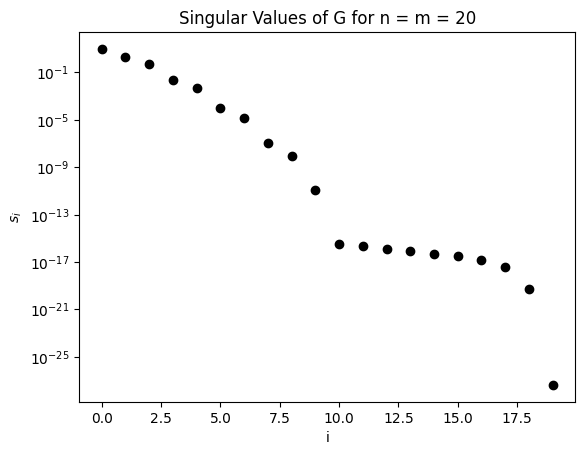

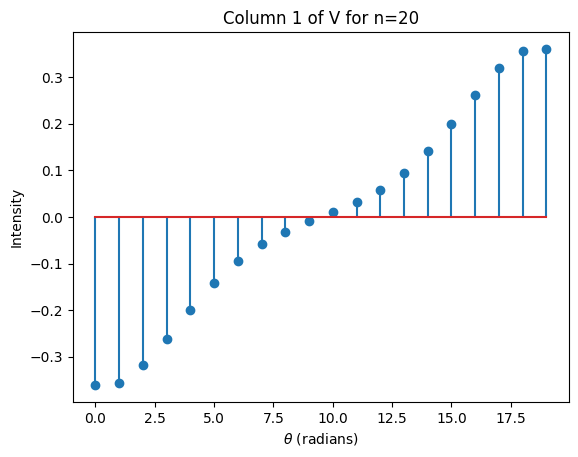

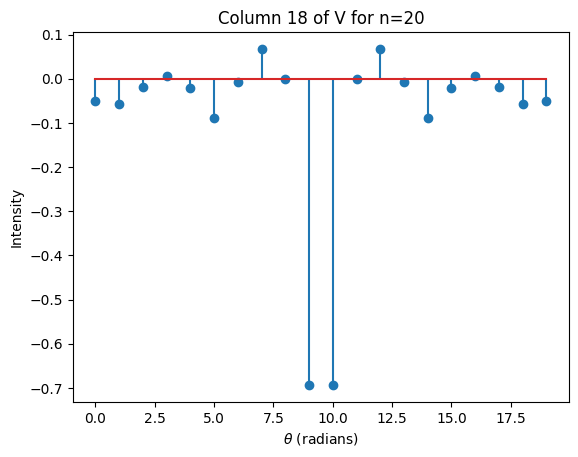

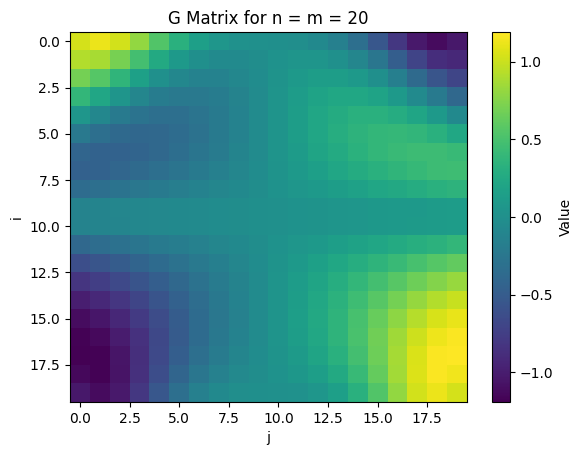

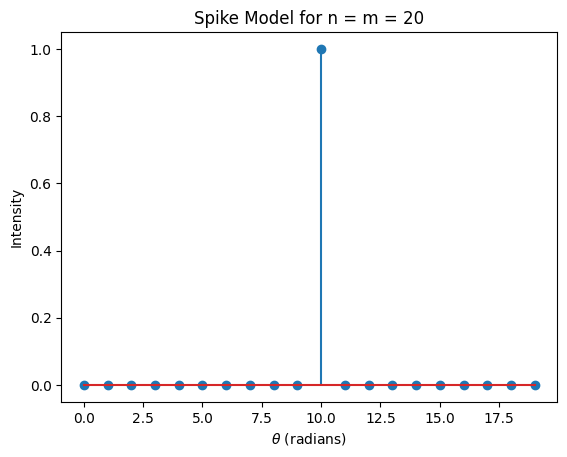

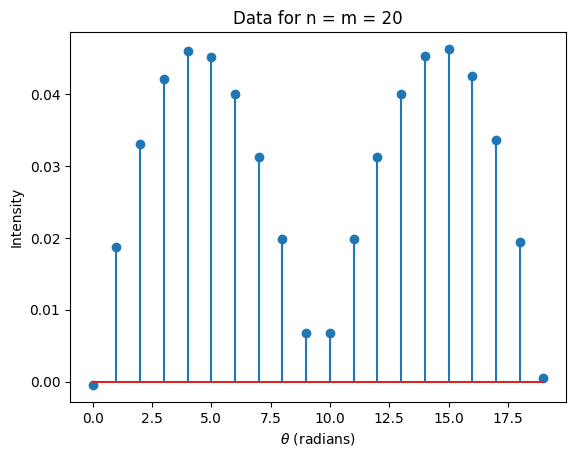

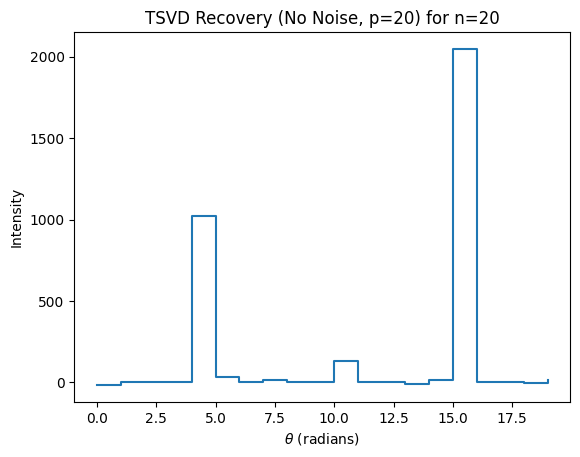

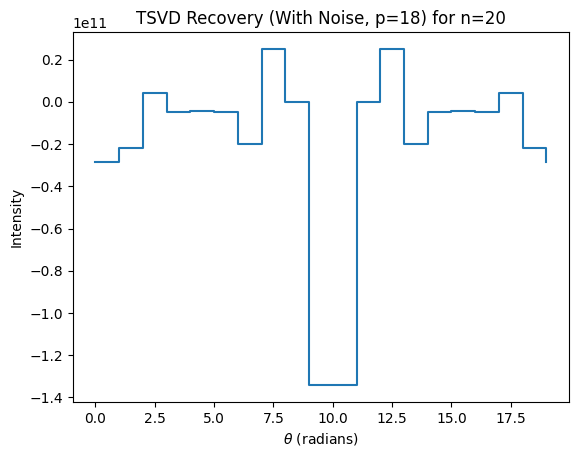

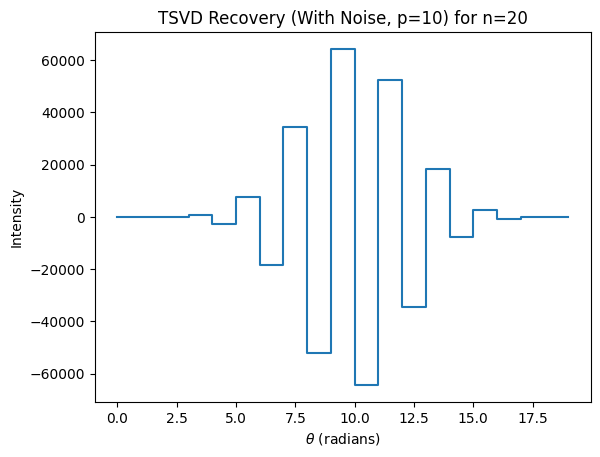

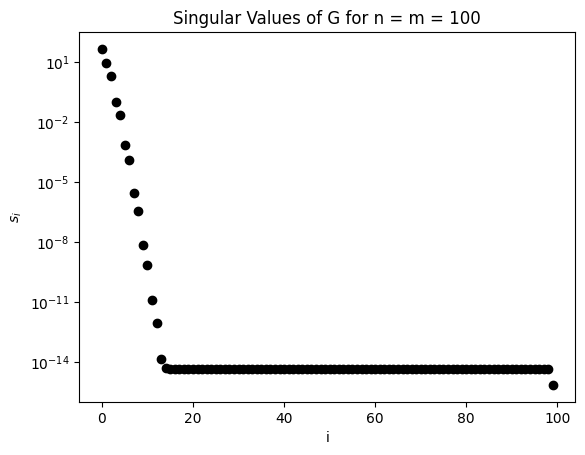

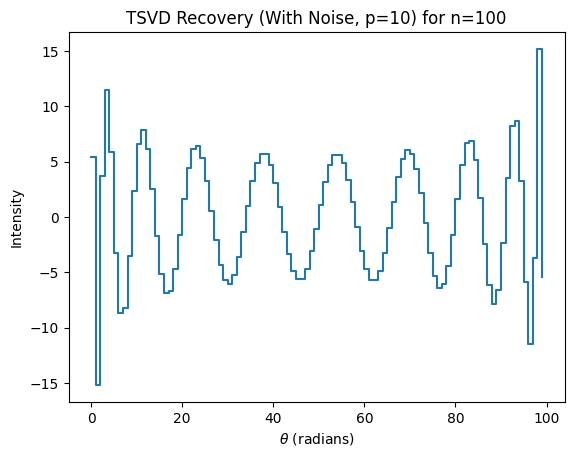

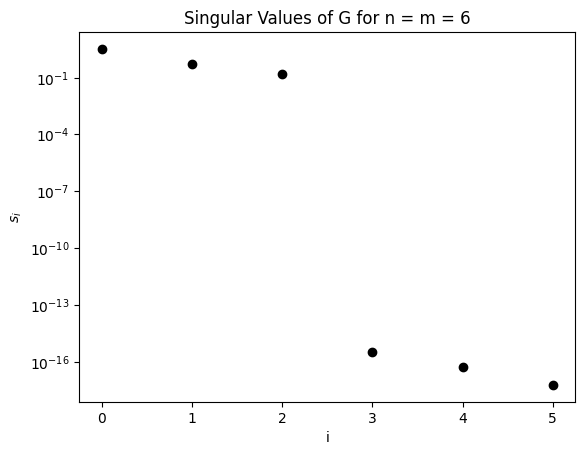

Condition number for n=20: 2.247299834465402e+28


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd
from scipy.special import fresnel

class ShawProblem:
    def __init__(self, n):
        """
        Initialize the Shaw problem for a given size n.

        Parameters:
        - n: int, size of the problem
        """
        self.n = n
        self.G, self.m, self.d = self.generate_shaw()
        self.U, self.S, self.Vt = svd(self.G, full_matrices=False)
        self.V = self.Vt.T

    def generate_shaw(self):
        """
        Generate the Shaw problem.

        Returns:
        - G: np.ndarray, the matrix representing the integral operator
        - m: np.ndarray, the spike model
        - d: np.ndarray, the data obtained by applying G to m
        """
        theta = np.linspace(-np.pi/2, np.pi/2, self.n)
        x = np.linspace(-1, 1, self.n)
        G = np.empty((self.n, self.n))

        # Generate G matrix using Fresnel integral
        for i in range(self.n):
            for j in range(self.n):
                sq = np.sqrt(np.pi / 2 * np.abs(theta[i]))
                c, s = fresnel(x[j] * sq)
                G[i, j] = sq * (c * np.sin(theta[i]) + s * np.cos(theta[i]))

        # Create spike model
        m = np.zeros(self.n)
        m[self.n // 2] = 1

        # Generate data
        d = G @ m

        return G, m, d

    def plot_data(self, title_suffix=""):
        """Plot G matrix, spike model, and data."""
        self._plot_matrix(self.G, 'G Matrix', title_suffix)
        self._plot_vector(self.m, 'Spike Model', title_suffix)
        self._plot_vector(self.d, 'Data', title_suffix)

    def plot_singular_vectors(self, indices=None):
        """Plot specific columns of the V matrix (singular vectors)."""
        if indices is None:
            indices = [0, self.n-1] if self.n > 1 else [0]

        for idx in indices:
            self._plot_vector(self.V[:, idx], f'Column {idx+1} of V', f'n={self.n}')

    def plot_singular_values(self, title_suffix):
        """Plot singular values of G."""
        plt.figure()
        plt.semilogy(self.S, 'ko')
        plt.xlabel('i')
        plt.ylabel('$s_i$')
        plt.title(f'Singular Values of G for {title_suffix}')
        plt.show()

    def plot_tsvd_recovery(self, d, p, noise_desc="No Noise"):
        """Plot TSVD recovery for given data."""
        m_tsvd = self.apply_tsvd(self.U, self.S, self.Vt, d, p)
        self._plot_vector_step(m_tsvd, f'TSVD Recovery ({noise_desc}, p={p})', f'n={self.n}')

    def apply_tsvd(self, U, S, Vt, d, p):
        """Apply Truncated Singular Value Decomposition (TSVD) to solve Gm = d."""
        Up = U[:, :p]
        Sp_inv = np.diag(1 / S[:p])
        Vtp = Vt[:p, :]
        Vp = Vtp.T
        m_tsvd = Vp @ Sp_inv @ Up.T @ d
        return m_tsvd

    def _plot_matrix(self, mat, label, title_suffix):
        plt.figure()
        plt.imshow(mat, aspect='auto', cmap='viridis')
        plt.title(f'{label} for {title_suffix}')
        plt.colorbar(label='Value')
        plt.xlabel('j')
        plt.ylabel('i')
        plt.show()

    def _plot_vector(self, vec, label, title_suffix):
        plt.figure()
        plt.stem(vec)
        plt.xlabel(r'$\theta$ (radians)')
        plt.ylabel('Intensity')
        plt.title(f'{label} for {title_suffix}')
        plt.show()

    def _plot_vector_step(self, vec, label, title_suffix):
        plt.figure()
        plt.step(range(len(vec)), vec, where='post')
        plt.xlabel(r'$\theta$ (radians)')
        plt.ylabel('Intensity')
        plt.title(f'{label} for {title_suffix}')
        plt.show()


    def condition_number(self):
        """Compute the condition number of the matrix G."""
        if self.S[-1] == 0:  # Check if the smallest singular value is zero
            return np.inf  # If the matrix is singular, the condition number is infinity
        return self.S[0] / self.S[-1]

# Example Usage:
shaw_20 = ShawProblem(20)
shaw_20.plot_singular_values('n = m = 20')
shaw_20.plot_singular_vectors(indices=[0, 17])
shaw_20.plot_data('n = m = 20')
shaw_20.plot_tsvd_recovery(shaw_20.d, 20)
noise_20 = np.random.normal(0, 1e-6, size=shaw_20.d.shape)
d20_noisy = shaw_20.d + noise_20
shaw_20.plot_tsvd_recovery(d20_noisy, 18, noise_desc="With Noise")
shaw_20.plot_tsvd_recovery(d20_noisy, 10, noise_desc="With Noise")

shaw_100 = ShawProblem(100)
shaw_100.plot_singular_values('n = m = 100')
noise_100 = np.random.normal(0, 1e-6, size=shaw_100.d.shape)
d100_noisy = shaw_100.d + noise_100
shaw_100.plot_tsvd_recovery(d100_noisy, 10, noise_desc="With Noise")

shaw_6 = ShawProblem(6)
shaw_6.plot_singular_values('n = m = 6')


shaw_20 = ShawProblem(20)
print("Condition number for n=20:", shaw_20.condition_number())

## Conclusion:

1. **Ill-conditioned Matrix:** A condition number of this magnitude indicates that the matrix \( G \) for \( n = 20 \) is severely ill-conditioned.

2. **Sensitivity:** Such a high condition number implies that the inverse problem associated with matrix \( G \) is highly sensitive to even tiny perturbations in the input data. This means that any small amount of noise or errors in the data \( d \) can lead to significant variations in the solution \( m \).

3. **Ill-posed Problem:** The large condition number corroborates the notion that Shaw's problem is ill-posed for the given size. In practice, solving ill-posed problems often requires regularization techniques or other methods that can stabilize the inversion process.

4. **Practical Implications:** Directly attempting to solve or invert the problem might result in significant numerical errors or instabilities. Specialized techniques or approximations might be needed to get a reliable solution.

In summary, the extreme condition number for \( n = 20 \) confirms that Shaw's problem is indeed challenging from a numerical standpoint, and care must be taken when attempting to solve it or interpret its solutions.